In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os

import pytorch_dataset
import pytorch_datamodule

import matplotlib.pyplot as plt
import pandas as pd

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [75]:
df = pd.read_csv('/Users/user/repos/zoobot-3d/data/gz3d_and_gz_desi_master_catalog.csv')
df = df[df['smooth-or-featured_featured-or-disk_fraction'] > 0.5]
df = df[df['disk-edge-on_yes_fraction'] < 0.5]
df = df[df['has-spiral-arms_yes_fraction'] > 0.5]
len(df)

9817

In [76]:
df['spiral_mask_exists'] = df['local_spiral_mask_loc'].apply(os.path.isfile)
df = df.query('spiral_mask_exists')
len(df)

1433

In [86]:
# df.columns.values

In [78]:
transform = A.Compose(
    [
        A.CenterCrop(250, 250)
    ],
    additional_targets={'spiral_mask': 'image', 'bar_mask': 'image'}
)
# transform = None

In [87]:
from zoobot.shared.schemas import decals_all_campaigns_ortho_schema

label_cols = decals_all_campaigns_ortho_schema.label_cols

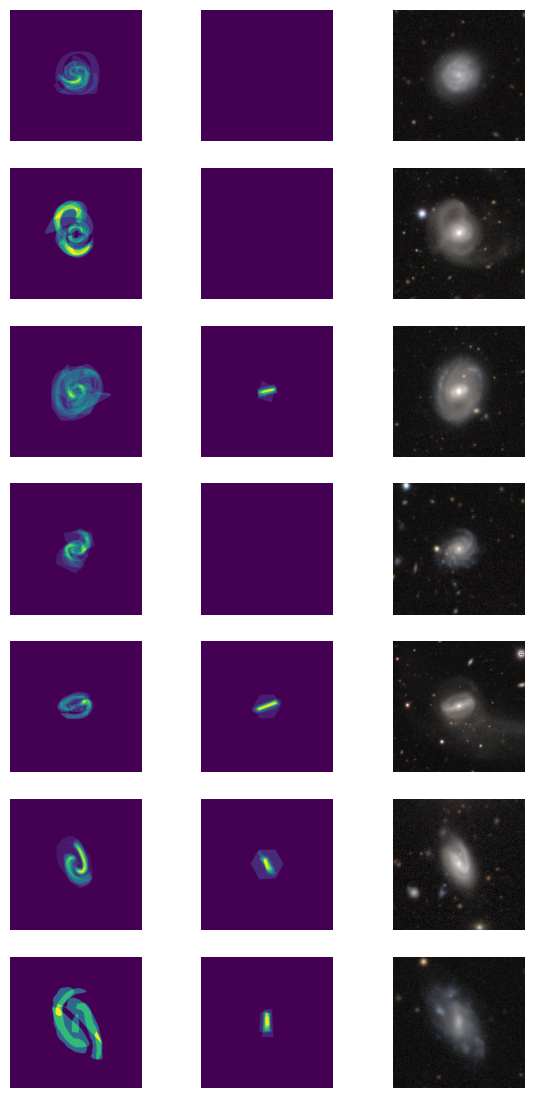

In [80]:
n_examples = 7

dataset = pytorch_dataset.SegmentationGalaxyDataset(
    df.sample(n_examples), transform=None, label_cols=label_cols)

fig, rows = plt.subplots(ncols=3, nrows=n_examples, figsize=(7, 2*n_examples))


for galaxy_n in range(n_examples):

    (ax0, ax1, ax2) = rows[galaxy_n]

    outputs = dataset[galaxy_n]
   
    ax0.imshow(outputs['spiral_mask'].squeeze())
    ax1.imshow(outputs['bar_mask'].squeeze())
    ax2.imshow(outputs['image'].squeeze())  # default target keyed as image
    ax0.axis('off')
    ax1.axis('off')
    ax2.axis('off')

plt.show()

In [81]:
print(outputs['spiral_mask'].max())

255


In [85]:
print(outputs['label_cols'])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## Check DataModule 

In [82]:
transform = A.Compose(
    [
        A.CenterCrop(250, 250),
        ToTensorV2()
    ],
    additional_targets={'spiral_mask': 'image', 'bar_mask': 'image'}
)

In [89]:
datamodule = pytorch_datamodule.SegmentationDataModule(
    train_catalog=df[:2],
    val_catalog=df[2:4],
    test_catalog=df[4:6],
    batch_size=2,
    num_workers=1,
    label_cols=label_cols,
    transform=transform
)
datamodule.setup('fit')

In [90]:
for batch in datamodule.train_dataloader():
    # print(len(batch))
    print(batch.keys())
    break

GZDESI/GZRings/GZCD not available from galaxy_datasets.pytorch.datasets - skipping
dict_keys(['image', 'spiral_mask', 'bar_mask', 'label_cols'])


In [91]:
batch['label_cols']

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])